In [1]:
import pandas as pd
from modeling import LightningBinConv
from data import TSDataset, TSDatasetTest
from torch.utils.data import DataLoader
# from preprocessing import get_preprocessing_pipeline
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [3]:
# download toy dataset to validate the methods
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
#hyperparameters
prediction_length = 36
context_length = 36
num_bins = 5000
min_value = -5
max_value = 5
offset = -36 # for train/test split

In [6]:
train_data = df.values[:offset]
test_data = df.values[offset-context_length:]

In [7]:
# pipeline = get_preprocessing_pipeline()

In [15]:
net = LightningBinConv(
      target_dim=1,
      prediction_length=prediction_length,
      context_length=context_length,
      freq=None,
      use_lags=False,
      num_bins=1000,
      min_bin_value=-5,
      max_bin_value= 5,
      is_prob_forecast=True,
      scaler_type= 'none', # or null
      kernel_size_across_bins_2d = 3, # prev: 3
      kernel_size_across_bins_1d = 3, # prev: 11 #what about 7,7?
      num_filters_2d = context_length,
      num_filters_1d = context_length,
      kernel_size_ffn = 51,
      num_1d_layers = 2,
      num_blocks = 3,
      dropout = 0.35,
      is_cum_sum = False
)

TypeError: object of type 'NoneType' has no len()

In [74]:
dataset = TSDataset(data=train_data, context_length=context_length, scaler=pipeline)
train_loader = DataLoader(dataset, batch_size=int(1e6), shuffle=True)

In [75]:
net

LightningBinConv(
  (conv): Conv2d(1, 32, kernel_size=(36, 1), stride=(1, 1))
  (conv1d_1): Conv1d(32, 32, kernel_size=(21,), stride=(1,))
  (conv1d_2): Conv1d(32, 5000, kernel_size=(21,), stride=(1,))
)

In [76]:
trainer = pl.Trainer(max_epochs=500)
trainer.fit(net, train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type   | Params | Mode 
--------------------------------------------
0 | conv     | Conv2d | 1.2 K  | train
1 | conv1d_1 | Conv1d | 21.5 K | train
2 | conv1d_2 | Conv1d | 3.4 M  | train
--------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.551    Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to

Training: |          | 0/? [00:00<?, ?it/s]

tensor(0.6928, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4422, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2165, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0840, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0483, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0372, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0368, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0411, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0413, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0424, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0492, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0465, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0412, device='mps:0', grad_fn=<

`Trainer.fit` stopped: `max_epochs=500` reached.


In [77]:
test_dataset = TSDatasetTest(data=test_data, context_length=context_length, scaler=train_loader.dataset.scaler)
test_loader = DataLoader(test_dataset, batch_size=int(1e6),shuffle=False)

In [78]:
test_sample = next(iter(test_loader))

In [79]:
test_sample.shape

torch.Size([36, 36, 1000])

In [80]:
import numpy as np

#TODO: this is ugly, rewrite in future
def extract_forecasts(pred_samples, window, context_length):
    """
    Extracts and concatenates forecast windows from pred_samples.

    Args:
        pred_samples (np.ndarray): Array of prediction samples (e.g. [num_samples, forecast_len]).
        window (int): Number of forecast windows to extract.
        context_length (int): Number of context steps between each forecast start.

    Returns:
        np.ndarray: Concatenated forecast windows.
    """
    indices = [(i * (context_length + 1)) for i in range(window)]
    windows = [pred_samples[i][:context_length] for i in indices]
    return np.concatenate(windows)

In [81]:
%%time
pred_samples = net.predict(test_sample, context_length)
pred_samples = pipeline.inverse_transform(pred_samples.numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
CPU times: user 1min 17s, sys: 7.84 s, total: 1min 25s
Wall time: 10.2 s


In [82]:
pred  = extract_forecasts(pred_samples, 1, context_length)

In [83]:
pred

array([370.29988102, 349.83724133, 408.66733044, 395.87818063,
       406.10950048, 464.93958958, 505.86486895, 505.86486895,
       452.15043977, 398.43601059, 349.83724133, 393.32035067,
       418.89865028, 403.55167051, 462.38175962, 459.82392966,
       462.38175962, 508.42269891, 546.79014833, 546.79014833,
       498.19137907, 462.38175962, 400.99384055, 462.38175962,
       475.17090942, 464.93958958, 503.30703899, 495.63354911,
       503.30703899, 549.34797829, 587.71542771, 587.71542771,
       539.11665845, 500.74920903, 457.2660997 , 498.19137907])

In [84]:
mae = np.mean(np.abs(pred - test_data[context_length:]))
print(f"MAE: {mae:.4f}")

MAE: 87.3960


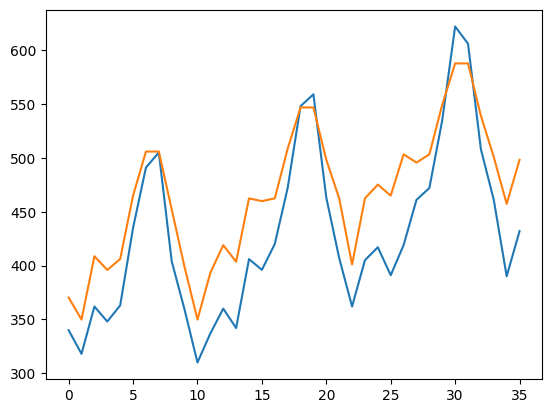

In [85]:
plt.plot(test_data[context_length:])
plt.plot(pred)

In [86]:
net.predict(test_sample, context_length)[0][10]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

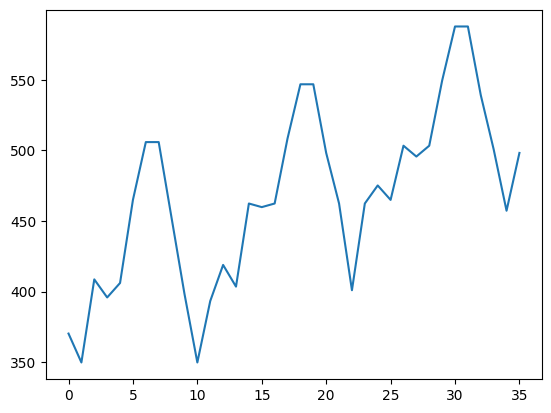

In [87]:
plt.plot(pred)

In [88]:
import torch

def most_probable_monotonic_sequence(p: torch.Tensor):
    """
    p: Tensor of shape (B, D) where each row is a probability vector
    Returns:
        best_sequences: Tensor of shape (B, D) with most probable [1...1, 0...0] sequence per batch
        best_probs: Tensor of shape (B,) with normalized probability of each best sequence
    """
    B, D = p.shape

    # Compute cumulative product of p and (1 - p)
    left_cumprod = torch.cumprod(p, dim=1)  # shape (B, D)
    right_cumprod = torch.cumprod((1 - p).flip(dims=[1]), dim=1).flip(dims=[1])  # shape (B, D)

    # Pad left with 1 at the beginning (per batch)
    ones = torch.ones((B, 1), dtype=p.dtype, device=p.device)
    left = torch.cat([ones, left_cumprod[:, :-1]], dim=1)  # shape (B, D)
    right = right_cumprod  # shape (B, D)

    # Element-wise multiply
    probs = left * right  # shape (B, D)

    # Normalize
    probs_sum = probs.sum(dim=1, keepdim=True)  # shape (B, 1)
    probs_normalized = probs / probs_sum

    # Find best cut index per batch
    best_k = torch.argmax(probs_normalized, dim=1)  # shape (B,)

    # Construct best sequences
    arange = torch.arange(D, device=p.device).unsqueeze(0)  # shape (1, D)
    best_k_expanded = best_k.unsqueeze(1)  # shape (B, 1)
    best_sequences = (arange < best_k_expanded).to(p.dtype)  # shape (B, D)

    # Get best normalized probabilities
    best_probs = torch.gather(probs_normalized, dim=1, index=best_k.unsqueeze(1)).squeeze(1)  # shape (B,)

    return best_sequences, best_probs

In [89]:
p = torch.tensor([[0.8, 0.9], [0.1, 0.1]])
v, prob = most_probable_monotonic_sequence(p.reshape(2,-1))
v

tensor([[1., 0.],
        [0., 0.]])

In [90]:
torch.cumprod(p, dim=0)

tensor([[0.8000, 0.9000],
        [0.0800, 0.0900]])

In [91]:
(0.8*0.9)/(0.8*0.9 + 0.8*0.1 + 0.2*0.1)

0.8780487804878049